In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import sys
sys.path.append('../../')

import tensorflow as tf
# tf.enable_eager_execution()
from tensorflow import gfile
import numpy as np
from tgs import data
import time
from matplotlib import pyplot as plt

np.set_printoptions(suppress=True,linewidth=np.nan,threshold=np.nan)

/home/jfaath/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jfaath/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/jfaath/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jfaath/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [6]:
config_dict = {
    'train_file_pattern': '/home/jfaath/projects/tgs/data/train/tfrecord/tgs*',
    'valid_file_pattern': '/home/jfaath/projects/tgs/data/train/tfrecord/tgs[3][6-9]',
    'test_file_pattern': '/home/jfaath/projects/tgs/data/test/tfrecord/tgs*',
    'shuf_buf': 50000,
    'parallel_calls': 8,
    'ext': {
        'resize_dim': 128,
        'resize_method': 'pad'
    }
}

batch_size = 20
num_epochs = 1

def run_data(idi, mode=tf.estimator.ModeKeys.TRAIN, iters=None, resize_mth='pad'):
    if iters is None:
        iters = 999999
    
    sess = tf.InteractiveSession()
    d = idi.input_fn(mode=mode)
    cnt = 0
    ids = []
    imgs = []
    masks = []
    resizes = []
    while True:
        try:
            img_dict, mask = sess.run(d)
            ids.extend(img_dict['id'])
            imgs.extend(img_dict['img'])
            masks.extend(mask)
            resizes.extend(img_dict[resize_mth])
            cnt += 1
            if cnt > iters:
                break
        except tf.errors.OutOfRangeError:
            print(f"Epoch finished on iteration {cnt}")
            break

    sess.close()
    tf.reset_default_graph()
    
    return ids, np.asarray(imgs), np.asarray(masks), np.asarray(resizes)


def plot_images_and_masks(ids, imgs, masks, count=4):
    fig, axes = plt.subplots(nrows=count, ncols=2, figsize=(10, 10 * (count // 2)), sharex=True, sharey=True)
    ax = axes.ravel()

    for i in range(count):
        ax[i * 2].imshow(imgs[i], cmap=plt.cm.gray, interpolation='none', aspect='auto')
        ax[i * 2].set_title(ids[i].decode())
        ax[i * 2 + 1].imshow(masks[i], cmap=plt.cm.gray, interpolation='none', aspect='auto')


In [7]:
%%time
idi = data.ImageDataInput(config_dict,
                          batch_size=batch_size,
                          num_epochs=num_epochs,
                          preprocess=False,
                          augment=False)

ids, imgs, masks, resizes = run_data(idi, iters=None, mode=tf.estimator.ModeKeys.EVAL)

INFO:tensorflow:File pattern: /home/jfaath/projects/tgs/data/train/tfrecord/tgs[3][6-9]
Epoch finished on iteration 20
CPU times: user 656 ms, sys: 53.8 ms, total: 710 ms
Wall time: 167 ms


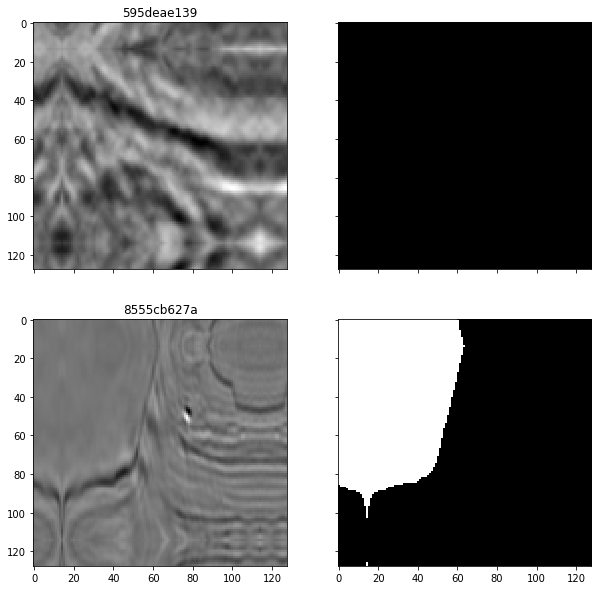

In [5]:
plot_images_and_masks(ids, imgs, masks, count=2)

In [ ]:
idx = 0

print('IMAGES')
print(f'shape: {imgs[idx].shape}, dtype: {imgs[idx].dtype}')
print(f'min: {np.min(imgs[idx])}, max: {np.max(imgs[idx])}')
print('MASKS')
print(f'shape: {masks[idx].shape}, dtype: {masks[idx].dtype}')
print(f'min: {np.min(masks[1])}, max: {np.max(masks[1])}')

In [17]:
images_pre = imgs[0:2]
masks_pre = masks[0:2]

transforms = [[0.8, 0.2, 0., 0., 1., 0., 0., 0.]]

imgt = tf.contrib.image.transform(images_pre, transforms, interpolation='NEAREST')
maskt = tf.contrib.image.transform(tf.expand_dims(masks_pre, axis=-1), transforms, interpolation='NEAREST')
maskt = tf.squeeze(maskt, axis=-1)

with tf.Session() as s:
    imgtt, masktt = s.run([imgt, maskt])
    
tf.reset_default_graph()

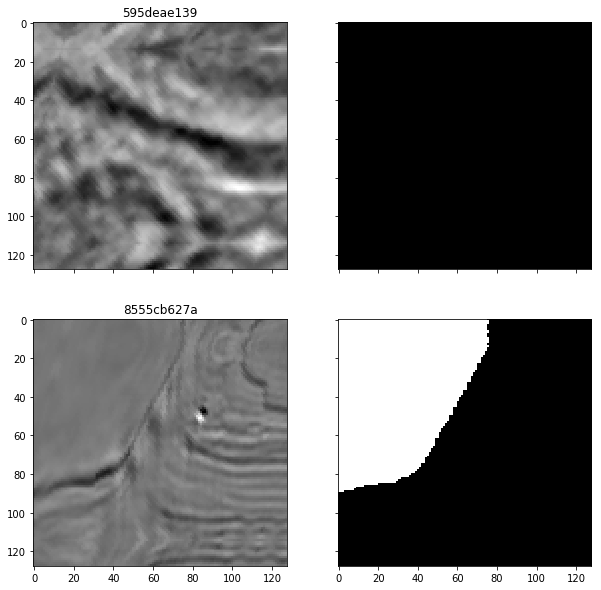

In [18]:
plot_images_and_masks(ids, imgtt, masktt, count=2)